
# Intro
In this tutorial we will execute a `dvmdostem` simulation from a Jupyter Notebook (IPython Notebook). The tutorial assumes:
* You have built all the `dvmdostem` Docker images (see the comments and directions in the [Dockerfile](https://github.com/ua-snap/dvm-dos-tem/blob/master/Dockerfile) and [Dockerfile-mapping-support](https://github.com/ua-snap/dvm-dos-tem/blob/master/Dockerfile-mapping-support). 
* You can launch the stack using `docker compose` (see directions and examples in the [docker-compose.yml](https://github.com/ua-snap/dvm-dos-tem/blob/master/docker-compose.yml) file).
* You have the volumes setup as specified in the project's `docker-compose.yml` file and you can access the files both from your host computer and from within the docker container(s).
* You have installed the Jupyter package and can run jupyter notebooks, specifically an `IPython` notebook.

> Note about packages and environments: the demo here shows a mixture of running dvm-dos-tem's supporting Python scripts "natively" (i.e. on your host computer, not in a Docker container) and running dvm-dos-tem's supporting Python scripts inside the Docker container. For the most consistent Python environment, it is best to run everyting through (inside) the Docker containers. However sometimes the extra typing required is onerous (`docker compose exec dvmdostem-run ...`), and there is a little extra overhead involved in interacting with the containers. So if you have the appropriate packages installed on your host machine you can run some of the scripts on your host as it shown here. This takes a little care to keep the paths straight for each command, i.e. whether you are referncing the path inside the guest/container, or on your host machine.

> Note that while `dmvdostem`'s supporting scripts are largely written in Python, for the most part there is not an exposed Python API. Instead the scripts are generally provided with a command line interface. So much of this tutorial, while running inside an IPython notebook, could easily be run directly from your shell.

For convenience we will add the `dvm-dos-tem` repo directory to our `PATH` on the host **before** launching the notebook (this should already be done for you inside the Docker container):

```bash
$ cd ~/path/to/your/dvm-dos-tem
$ export PATH=$(PWD)/scripts:$(PWD):$PATH
```

Now start the notebook server:

```bash
$ jupyter notebook
```

and open this notebook in a browser tab. 

**Note that when you open the notebook, the current working directory of the notebook will be the dvm-dos-tem scripts directory. In order for the docker commands to work correctly, you must change your working directory for this notebook to the main dvm-dos-tem repo directory, which contains the Dockerfile(s).** You can do this a variety of ways, but the easiest is the builtin IPython magic, `%cd </path/to/your/dvm-dos-tem>`. There is also the useful `%pwd` function to see where you are.



# Setup

As noted in [this wiki page](https://github.com/ua-snap/dvm-dos-tem/wiki/How-To:-Run-dvmdostem-and-plot-output-via-Docker) there are 6 general steps for any modeling task: 

1. Decide where on your computer you want to store your model run(s).
2. Decide what spatial (geographic) area you want to run.
3. Decide what variables you want to have output
4. Decide on all other run settings/parameters:
 * Which stages to run and for how many years.
 * Is the community type (CMT) fixed or driven by input vegetation.nc map?
 * For which stages should the output files be generated and saved?
 * Calibration settings if necessary (`--cal-mode`).
 * Any other command line options or environment settings.
5. Launch the run
6. Make plots or other analysis.

## Setup data location and geographic location.

Start by setting up a directory for this example run. There are several ways you could do this. For this example we will run the script inside the docker container. Hence the paths will be from the point of view of inside the docker container.

In [8]:
# Cleanup:
!docker compose exec dvmdostem-run rm -r /data/workflows/testcase_0001

In [9]:
!docker compose exec dvmdostem-run scripts/setup_working_directory.py \
--input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_TOOLIK_FIELD_STATION_10x10/ \
/data/workflows/testcase_0001

Now note that if you investigate **from your host** (i.e. not inside the docker container) you can see the new directory you just created (in my case, I keep the workflows up two directories from my dvm-dos-tem repo; your paths might be different):

In [10]:
!ls ../dvmdostem-workflows/testcase_0001/

calibration config      output      parameters  run-mask.nc


Notice that you can see the same folders and files by running `ls` from within the docker container. Notice the paths are different because you are referencing the locations **inside** the container as oppsed to from your host computer:

In [11]:
!docker compose exec dvmdostem-run ls /data/workflows/testcase_0001

## Adjust spatial mask
Now adjust your run mask so as to only run one pixel:

In [12]:
!docker compose exec dvmdostem-run runmask-util.py --reset \
--yx 0 0 \
--show \
/data/workflows/testcase_0001/run-mask.nc

## Choose output variables

OK, now its time to turn on some outputs. In this case, lets keep it simple and just turn on monthly GPP for PFTs. The output from this command needs a wider display for easier reading. First check on what is already on:

In [13]:
!docker compose exec dvmdostem-run outspec_utils.py -s /data/workflows/testcase_0001/config/output_spec.csv

This is super annoying because it needs a wider screen to display this table nicely. But we can use `pandas` to display nicely in this notebook.

In [14]:
import pandas as pd
outspec = pd.read_csv('../dvmdostem-workflows/testcase_0001/config/output_spec.csv')
outspec.head(15)

/Users/tobeycarman/.pyenv/versions/3.8.2/envs/py38-ddt2/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,Name,Description,Units,Yearly,Monthly,Daily,PFT,Compartments,Layers,Data Type,Placeholder
0,ALD,Soil active layer depth,m,NaN,invalid,invalid,invalid,invalid,invalid,double,NaN
1,AVLN,Total soil available N,g/m2,NaN,NaN,invalid,invalid,invalid,NaN,double,NaN
2,BURNAIR2SOIN,Nitrogen deposit from fire emission,g/m2/time,NaN,NaN,invalid,invalid,invalid,invalid,double,NaN
3,BURNSOIC,Burned soil C,g/m2/time,NaN,NaN,invalid,invalid,invalid,invalid,double,NaN
4,BURNSOILN,Burned soil N,g/m2/time,NaN,NaN,invalid,invalid,invalid,invalid,double,NaN
5,BURNTHICK,Ground burn thickness,m,NaN,NaN,invalid,invalid,invalid,invalid,double,NaN
6,BURNVEG2AIRC,Burned vegetation C to atmosphere,g/m2/time,NaN,NaN,invalid,invalid,invalid,invalid,double,NaN
7,BURNVEG2AIRN,Burned vegetation N to atmosphere,g/m2/time,NaN,NaN,invalid,invalid,invalid,invalid,double,NaN
8,BURNVEG2DEADC,Burned vegetation C to standing dead C,g/m2/time,NaN,NaN,invalid,invalid,invalid,invalid,double,NaN
9,BURNVEG2DEADN,Burned vegetation N to standing dead N,g/m2/time,NaN,NaN,invalid,invalid,invalid,invalid,double,NaN


Now use the utility helper script to change the file:

In [15]:
!docker compose exec dvmdostem-run outspec_utils.py \
/data/workflows/testcase_0001/config/output_spec.csv \
--on GPP p m

!docker compose exec dvmdostem-run outspec_utils.py \
/data/workflows/testcase_0001/config/output_spec.csv \
--on CMTNUM y


                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
                 GPP            g/m2/time            y            m      invalid            p                   invalid       double     GPP
                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
              CMTNUM                    m            y      invalid      invalid      invalid      invalid      invalid          int     Community Type Number


## Adjust other settings

Now modify the config file to turn on equilibrium stage outputs. Again there are about 100 ways to do this (on the host, in the container, with a text editor, programatically, etc). For these purposes, we will work from the host, mostly so we can record (and run) the Python snippet here in the notebook:

In [16]:
import json

CONFIG_FILE = '../dvmdostem-workflows/testcase_0001/config/config.js'

# Read the existing data into memory
with open(CONFIG_FILE, 'r') as f:
    config = json.load(f)

# Modify it
config['IO']['output_nc_eq'] = 1

# Write it back..
with open(CONFIG_FILE, 'w') as f:
    json.dump(config, f, indent=2)

Note you can check on the file with `!cat {CONFIG_FILE}`.

# RUN

Now finally we will launch our `dvmdostem` run. For these purposes, we are just doing a 200 year equlibrium run. We are going to force this to run as CMT 4 (Tussock Tundra).

In [17]:
!docker compose exec --workdir /data/workflows/testcase_0001 dvmdostem-run \
dvmdostem -p 50 -e 200 -s 0 -t 0 -n 0 -l err --force-cmt 4

Setting up logging...
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 5
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 6
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 7
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 8
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 9
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 10
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 11
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 12
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 13
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 14
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 15
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 16
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 17
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 18
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 19
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 20
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 21
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 22
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 23
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 24
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 25


[err] [EQ->Y] y: 0 x: 0 Year: 186
[err] [EQ->Y] y: 0 x: 0 Year: 187
[err] [EQ->Y] y: 0 x: 0 Year: 188
[err] [EQ->Y] y: 0 x: 0 Year: 189
[err] [EQ->Y] y: 0 x: 0 Year: 190
[err] [EQ->Y] y: 0 x: 0 Year: 191
[err] [EQ->Y] y: 0 x: 0 Year: 192
[err] [EQ->Y] y: 0 x: 0 Year: 193
[err] [EQ->Y] y: 0 x: 0 Year: 194
[err] [EQ->Y] y: 0 x: 0 Year: 195
[err] [EQ->Y] y: 0 x: 0 Year: 196
[err] [EQ->Y] y: 0 x: 0 Year: 197
[err] [EQ->Y] y: 0 x: 0 Year: 198
[err] [EQ->Y] y: 0 x: 0 Year: 199
cell 0, 0 complete.33
[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping ce

Thats it! If we look in the output directory, we expect to see one output file for the equlibrium stage, GPP:

In [18]:
!docker compose exec dvmdostem-run ls /data/workflows/testcase_0001/output

In [19]:
!ncdump ../dvmdostem-workflows/testcase_0001/output/run_status.nc


netcdf run_status {
dimensions:
	Y = 10 ;
	X = 10 ;
variables:
	int run_status(Y, X) ;
data:

 run_status =
  100, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ;
}


# Plotting

Again, this can be done a few ways (host or guest). For these purposes, we will run on the host.

In [20]:
import netCDF4 as nc
import scripts.output_utils as ou
import matplotlib.pyplot as plt

The output_utils script has a bunch of unfinished plotting tools in it and some useful funcitons for summarizing outputs (i.e. summing PFTs or converting monthly outputs to yearly).

First just see what output files we have to work with:

In [21]:
!ls ../dvmdostem-workflows/testcase_0001/output/

CMTNUM_yearly_eq.nc restart-eq.nc       restart-sc.nc       restart-tr.nc
GPP_monthly_eq.nc   restart-pr.nc       restart-sp.nc       run_status.nc


### Summarize to yearly, plot first 5 PFTs

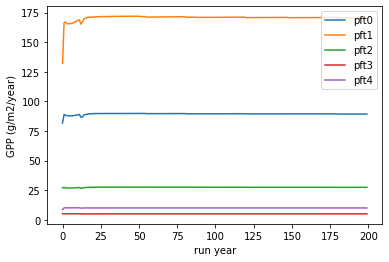

In [22]:
ds = nc.Dataset("../dvmdostem-workflows/testcase_0001/output/GPP_monthly_eq.nc")
gpp = ds.variables['GPP'][:]
yrly_gpp = ou.sum_monthly_flux_to_yearly(gpp)
for pft in range(0,5):
    plt.plot(yrly_gpp[:,pft,0,0], label='pft{}'.format(pft))
plt.xlabel('run year')
plt.ylabel('{} ({})'.format('GPP', 'g/m2/year'))
_ = plt.legend()

### Summarize to yearly, sum PFTs 

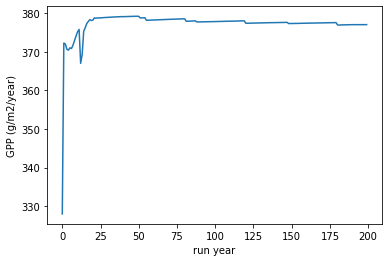

In [23]:
plt.plot(ou.sum_across_pfts(yrly_gpp)[:,0,0], label='all pfts')
plt.xlabel('run year')
_ = plt.ylabel('GPP (g/m2/year)')

### Plot the last 10 years at monthly resolution, first 5 PFTs

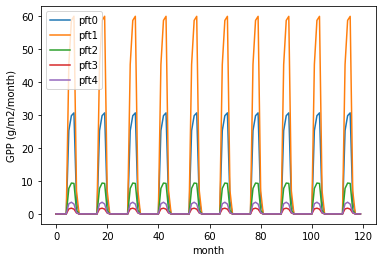

In [24]:
import netCDF4 as nc
ds = nc.Dataset("../dvmdostem-workflows/testcase_0001/output/GPP_monthly_eq.nc")
gpp = ds.variables['GPP'][:]
for pft in range(0,5):
    plt.plot(gpp[-120:,pft,0,0], label='pft{}'.format(pft))
plt.xlabel('month')
plt.ylabel('GPP ({})'.format(ds.variables['GPP'].units))
_ = plt.legend()

### Unfinished output_utils.py plot function

Trying to open:  ../dvmdostem-workflows/testcase_0001/output/GPP_monthly_eq.nc
(2400, 10, 10, 10)


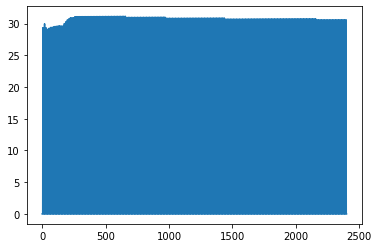

In [25]:
ou.plot_basic_timeseries(['GPP'],0,0,'monthly',['eq'],'../dvmdostem-workflows/testcase_0001/output/')